In [1]:
import flwr as fl 
import pandas as pd
import os 
import pickle
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import tasks as ts
import warnings
import argparse
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from typing import Dict

import matplotlib.pyplot as plt

from flwr.common import NDArrays



In [2]:
data_1 = pd.read_csv('../IID_df_1.csv')
data_2 = pd.read_csv('../IID_df_2.csv')

In [3]:
scaler = MinMaxScaler()
smote = SMOTE(random_state=422)


In [4]:
test = pd.read_csv('../test_glob.csv')

In [5]:
X_train, y_train = data_1.drop(columns=["Fraud"]), data_1["Fraud"]


X_train_scale = scaler.fit_transform(X_train)
X_train_, y_train_ = smote.fit_resample(X_train_scale, y_train)



X_test, y_test = test.drop(columns='Fraud'), test.Fraud 
X_test_scale = scaler.transform(X_test)

model = LogisticRegression(
max_iter=10
)

In [7]:
# model.fit(X_train_2, y_train_2)
# y_pred_proba = model.predict_proba(X_test_scale)[:, 1]
# y_pred = model.predict(X_test_scale)

# loss = log_loss(y_test, y_pred_proba)
# accuracy = accuracy_score(y_test, y_pred)
# roc_auc = roc_auc_score(y_test, y_pred_proba)
# f1 = f1_score(y_test, y_pred)



In [8]:
# (loss, accuracy, roc_auc, f1)

In [6]:
X_train, X_test, y_train, y_test = X_train_, X_test_scale, y_train_, y_test

In [7]:


def plot_metrics(losses, ROC_AUC, ACCURACY, F1):
   
    rounds = list(range(1, len(losses) + 1))
    
    plt.figure(figsize=(12, 8))
  
    plt.subplot(2, 2, 1)
    plt.plot(rounds, losses, color='blue')
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(2, 2, 2)
    plt.plot(rounds, ROC_AUC, color='green')
    plt.title("ROC AUC over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("ROC AUC")

    plt.subplot(2, 2, 3)
    plt.plot(rounds, ACCURACY, color='orange')
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.subplot(2, 2, 4)
    plt.plot(rounds, F1, color='red')
    plt.title("F1 Score over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")

    plt.tight_layout()
    plt.show()



In [17]:
class CustomClientDP(fl.client.NumPyClient):
  
    def __init__(self, model, X_train, X_test, y_train, y_test):
        self.model = model
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.losses = []
        self.ROC_AUCs = []
        self.ACCURACYs = []
        self.F1s = []

    def get_parameters(self, config):
         
        return ts.get_model_parameters(model)
    
    def fit(self, parameters, config):
        ts.set_model_parameters(model, parameters)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(X_train, y_train)
    
        
        return ts.get_model_parameters(model), len(X_train), {}

    def evaluate(self, parameters, config):
        
        ts.set_model_parameters(model, parameters)
        
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        
       
        loss = log_loss(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        f1 = f1_score(y_test, y_pred)

        print(f'accuracy: {accuracy}')
        print(f'ROC_AUC: {roc_auc}')
        print(f'f1_score: {f1}')

        
        self.losses.append(loss)
        self.ROC_AUCs.append(roc_auc)
        self.ACCURACYs.append(accuracy)
        self.F1s.append(f1)
        
        
        return loss, len(X_test), {"accuracy": accuracy, "roc_auc": roc_auc, "f1-score": f1}


if __name__ == "__main__":
    N_CLIENTS = 2

    model = LogisticRegression(
        max_iter=1,
        warm_start=True
    )

    ts.set_initial_parameters(model)
    
    
    client_dp = CustomClientDP(model, X_train, X_test, y_train, y_test)

    
    fl.client.start_client(
        server_address="127.0.0.1:8080",
        client=client_dp
    )


INFO :      
INFO :      Received: train message 54b7e784-d122-4a33-a057-1527bde09331
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 69169e8f-b15e-45ba-9fa9-e56cc2f6abfb


INFO :      Sent reply
INFO :      
INFO :      Received: train message 2a791e65-3ef5-4218-af18-1c1d09c3b592
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message e41e8a9d-7525-4f24-816f-d3216c6524b2
INFO :      Sent reply
INFO :      
INFO :      Received: train message 57f781ce-bada-48e4-a5eb-8fe00b9bbdb1
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 813eb987-f22e-4a5c-aa1f-5aafa81d4c22
INFO :      Sent reply
INFO :      
INFO :      Received: train message 449c169e-8cdc-4495-9c11-3cf3f266144d
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message e26e5bf1-295c-4650-ac06-4cfeaa5ba81c
INFO :      Sent reply


accuracy: 0.7840466926070039
ROC_AUC: 0.6563590449954088
f1_score: 0.14175257731958762
accuracy: 0.8715953307392996
ROC_AUC: 0.6954660238751148
f1_score: 0.17154811715481172
accuracy: 0.8939688715953308
ROC_AUC: 0.7132288797061525
f1_score: 0.15503875968992248
accuracy: 0.6679636835278858
ROC_AUC: 0.7134507958371594
f1_score: 0.1949685534591195


INFO :      
INFO :      Received: train message 3cbe7d42-bfa0-4d55-ac2d-8948646f2ae6
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message b81c3adf-ff2a-4ca5-b080-a85adcb3268f
INFO :      Sent reply
INFO :      
INFO :      Received: train message dd2c2a4d-ca1f-48aa-98e2-a021086df015
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 7248d4da-714f-4304-b1a4-d98347e78f7d
INFO :      Sent reply
INFO :      
INFO :      Received: train message a2c3f33c-c00c-4475-96f4-cad87a3d8b3d
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 8470f9e4-c8f4-4ab7-a962-bc7c657a90db
INFO :      Sent reply
INFO :      
INFO :      Received: train message edf91953-4a71-4d9b-b48a-79d3c481dd8f
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 50ed87c2-d60e-4705-9d2b-14f47d9b5230


accuracy: 0.9101815823605707
ROC_AUC: 0.7343089990817264
f1_score: 0.11501597444089456
accuracy: 0.8265239948119325
ROC_AUC: 0.7240377257422711
f1_score: 0.1807044410413476
accuracy: 0.7068741893644618
ROC_AUC: 0.7214589072543619
f1_score: 0.18996415770609318


INFO :      Sent reply
INFO :      
INFO :      Received: train message 2a602651-7ed7-4d2a-8db9-a477d151d86c
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 12d83c69-5dae-432d-aa5c-f926622f003a
INFO :      Sent reply
INFO :      
INFO :      Received: train message 7602b220-eb56-42b1-8869-f63eae06e6c3
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 059b238f-9e01-4c9d-98e2-a9cd72eb99ea
INFO :      Sent reply
INFO :      
INFO :      Received: train message 40e0df08-8a50-4fbd-b4c7-463ffea40f7a
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 389bcad2-b115-40ae-9973-6e7fc92179b9
INFO :      Sent reply
INFO :      
INFO :      Received: train message 011466a7-8ddb-4539-9e54-360f330098da
INFO :      Sent reply


accuracy: 0.7078469520103762
ROC_AUC: 0.7301232017141108
f1_score: 0.20194862710363154
accuracy: 0.7039559014267186
ROC_AUC: 0.7288758800122437
f1_score: 0.20122484689413822
accuracy: 0.6987678339818417
ROC_AUC: 0.7283268288950108
f1_score: 0.19982773471145565
accuracy: 0.6592088197146563
ROC_AUC: 0.7301939853076217
f1_score: 0.1946360153256705


INFO :      
INFO :      Received: evaluate message d8ec7e6f-dc1d-4934-95e0-03b0ff450afa
INFO :      Sent reply
INFO :      
INFO :      Received: train message 29a3ff50-4801-4143-8514-a42421011ed5
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message aaf46349-f156-4216-85ef-2fb398cfc792
INFO :      Sent reply
INFO :      
INFO :      Received: train message 92111ec3-51f7-43ce-b436-e2651b57ae64
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 90f74471-a4d8-407a-88c2-6bc2db48790d
INFO :      Sent reply
INFO :      
INFO :      Received: train message 7aa146d9-515c-4e6e-beca-b9515087b7b4
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message cd993b85-5c9e-40b2-8bad-234ed734994e
INFO :      Sent reply
INFO :      
INFO :      Received: train message 645fddca-fe64-4403-8132-427d11c59546
INFO :      Sent reply
INFO :      


accuracy: 0.6725032425421531
ROC_AUC: 0.7316307009488828
f1_score: 0.20094936708860758
accuracy: 0.7016861219195849
ROC_AUC: 0.7359695439240894
f1_score: 0.2041522491349481
accuracy: 0.6942282749675746
ROC_AUC: 0.7373106060606059
f1_score: 0.2042194092827004
accuracy: 0.7266536964980544
ROC_AUC: 0.7398090756045301
f1_score: 0.2009478672985782


INFO :      Received: evaluate message 4acfab95-7914-4a9a-ade0-9c811a501b18
INFO :      Sent reply
INFO :      
INFO :      Received: train message 733e5c47-fe65-4d9e-b584-91984500167a
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 0c0a8f1b-9e89-42ce-9020-cdc507347a8c
INFO :      Sent reply
INFO :      
INFO :      Received: train message 6c9f832b-ac39-4481-9d52-35ce97ed560d
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message f8148b02-25c5-4521-ada0-805c74cc89c7
INFO :      Sent reply
INFO :      
INFO :      Received: train message 7869e06c-30a2-434f-b6d7-09e72014c4ff
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message a4bf2122-2081-4984-84fc-4d721e76665c
INFO :      Sent reply


accuracy: 0.6796368352788587
ROC_AUC: 0.7387645393327211
f1_score: 0.20706260032102727
accuracy: 0.6611543450064851
ROC_AUC: 0.7397555096418733
f1_score: 0.20168067226890757
accuracy: 0.680609597924773
ROC_AUC: 0.7406756963575145
f1_score: 0.20883534136546184
accuracy: 0.6575875486381323
ROC_AUC: 0.7415097949188859
f1_score: 0.20241691842900303


INFO :      
INFO :      Received: train message ddbff011-a400-4af2-8883-17745a8042d1
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 969d82c8-bd83-4929-87d8-d253d22c45c2
INFO :      Sent reply
INFO :      
INFO :      Received: train message dd2c21b1-316a-4a76-9caa-518e3c6d0f88
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message d70f80f8-cf58-4a98-92b6-db4763331fb7
INFO :      Sent reply
INFO :      
INFO :      Received: train message 03a633b2-530d-42f7-b81b-57b916dfcb02
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 68610cd9-0bc8-4299-8022-a7d10224ef0a
INFO :      Sent reply
INFO :      
INFO :      Received: train message bdddadaa-1659-49f4-884a-b9ef88e063a3
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message cfd19444-6d90-4a28-87ba-a94c6d29fc9b
INFO :      Sent reply
INFO :      
INFO :      Received: train message bb4d4feb-bafd-4e93-a662-df2e734ff3cb
INFO :      Sent reply


accuracy: 0.680609597924773
ROC_AUC: 0.7422157177838996
f1_score: 0.21010425020048115
accuracy: 0.6770428015564203
ROC_AUC: 0.7428259871441689
f1_score: 0.21077654516640254
accuracy: 0.6848249027237354
ROC_AUC: 0.7439566115702481
f1_score: 0.2097560975609756
accuracy: 0.6845006485084306
ROC_AUC: 0.7447122742577288
f1_score: 0.20958570268074736


INFO :      
INFO :      Received: evaluate message a5e42786-c3f5-42d1-b4d8-5c67277a4dae
INFO :      Sent reply
INFO :      
INFO :      Received: train message 8b5e0101-89d3-47b7-b532-c05098df7106
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 213f11cd-a77f-4346-afe4-e24bab09df57
INFO :      Sent reply
INFO :      
INFO :      Received: train message c6f29b76-d749-42dd-8483-6701179822ea
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 23af5d78-59b5-4426-953e-4cd772b8c21c
INFO :      Sent reply
INFO :      
INFO :      Received: train message 18ae35e1-baaa-4338-9741-5092ee20bd5f
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 0e1cf5c0-0b9d-4b4d-b13c-46ac0df13b91
INFO :      Sent reply
INFO :      
INFO :      Received: train message 01592ea8-7257-4f12-bb38-9149ae3172db
INFO :      Sent reply


accuracy: 0.6851491569390402
ROC_AUC: 0.7451484542393634
f1_score: 0.2073469387755102
accuracy: 0.6734760051880675
ROC_AUC: 0.7450642791551885
f1_score: 0.208955223880597
accuracy: 0.6624513618677043
ROC_AUC: 0.7452058463422101
f1_score: 0.20594965675057209
accuracy: 0.6605058365758755
ROC_AUC: 0.7456133302724213
f1_score: 0.20741862225586677


INFO :      
INFO :      Received: evaluate message ba2c5a20-0938-4cba-8e34-378ed0f938b0
INFO :      Sent reply
INFO :      
INFO :      Received: train message 099f4f15-baa7-4f0e-b4a2-5f2dfda10775
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 60f40eef-ffbc-4fdd-afbc-87e684313b63
INFO :      Sent reply
INFO :      
INFO :      Received: train message efc721a8-0350-4de2-a490-5e02c52c0cb6
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 02c0c2b2-56d5-40b6-91f4-ff2184e1b041
INFO :      Sent reply
INFO :      
INFO :      Received: train message 1b615896-ae3b-4c24-b18a-36093e7d2c30
INFO :      Sent reply


accuracy: 0.6682879377431906
ROC_AUC: 0.7461623813896541
f1_score: 0.20759101471727343
accuracy: 0.6686121919584954
ROC_AUC: 0.745992118151209
f1_score: 0.2052877138413686
accuracy: 0.6715304798962386
ROC_AUC: 0.7462580348943986
f1_score: 0.204241948153967


INFO :      
INFO :      Received: evaluate message 7f40c55f-bd06-4b67-bacb-e90c7fafb689
INFO :      Sent reply
INFO :      
INFO :      Received: train message 2a3bdd08-3b68-42fb-a2e6-bd2bfee71cb6
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 0509222a-ca18-42bd-a943-f90ea9c1f499
INFO :      Sent reply
INFO :      
INFO :      Received: train message 98e0b2dd-5ff9-4fe2-9b03-fd3a0cf76a35
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 8a90aca6-aef9-4d57-b525-5747358bd4a8
INFO :      Sent reply
INFO :      
INFO :      Received: train message 45d5a6b8-509e-412d-8a94-688f37efa1c1
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 46befbc4-8197-464c-81a2-75c94863c8fd
INFO :      Sent reply
INFO :      
INFO :      Received: train message 1cf29a6a-b045-4854-9c89-ac304141a3e6
INFO :      Sent reply
INFO :      


accuracy: 0.6702334630350194
ROC_AUC: 0.7464627333945517
f1_score: 0.20360219263899765
accuracy: 0.6695849546044098
ROC_AUC: 0.7466329966329966
f1_score: 0.2032838154808444
accuracy: 0.670881971465629
ROC_AUC: 0.7468855218855219
f1_score: 0.20392156862745098
accuracy: 0.6695849546044098
ROC_AUC: 0.7469677838996021
f1_score: 0.2032838154808444


INFO :      Received: evaluate message 9499048e-61b2-421a-ab3a-a5f2490bc18b
INFO :      Sent reply
INFO :      
INFO :      Received: train message b4a2bff7-5828-45ed-bf55-8e0a1173387c
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 99cd6b47-186a-4344-a10c-6964c025d18b
INFO :      Sent reply
INFO :      
INFO :      Received: train message 2c6ea85d-c8a7-44ee-9698-ffd2b4550241
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message fd1f433c-c5d6-4679-ba58-2c55191b26b2
INFO :      Sent reply
INFO :      
INFO :      Received: train message e4d72a3a-ac6c-4158-acd4-1365f5e14e40
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 1aa2105c-3887-4b88-8b00-a43685f9dd4f
INFO :      Sent reply
INFO :      
INFO :      Received: train message 3254c54b-e979-4fe1-9a8a-e0ff64fcb439
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 63bd22e8-677d-481c-8391-b0aeba46cf8c


accuracy: 0.669260700389105
ROC_AUC: 0.7470576981940619
f1_score: 0.203125
accuracy: 0.6705577172503242
ROC_AUC: 0.7472126568717479
f1_score: 0.20376175548589343
accuracy: 0.6705577172503242
ROC_AUC: 0.747208830731558
f1_score: 0.20376175548589343
accuracy: 0.670881971465629
ROC_AUC: 0.7472183960820323
f1_score: 0.20392156862745098


INFO :      Sent reply
INFO :      
INFO :      Received: train message 9f5e7445-2006-4c89-96e3-476c728c1425
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message e93825a1-1831-409b-87cb-8e6e3aa691b0
INFO :      Sent reply
INFO :      
INFO :      Received: train message c9003738-c225-4a79-8b7c-8e6e0518ed74
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message dd9cd024-ea41-46ed-840d-5ef8c1523e3d
INFO :      Sent reply
INFO :      
INFO :      Received: train message e67d1a15-a2b5-4839-8bee-c9d3d842aa13
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 923242da-dedd-4ecd-b939-43a0046f8413
INFO :      Sent reply
INFO :      
INFO :      Received: train message 143925cb-6697-49d6-86cd-31fb246a2833
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message a0c40b15-7882-4e11-bf4e-a329e8cfa26e
INFO :      Sent reply
INFO :      


accuracy: 0.6712062256809338
ROC_AUC: 0.7472796143250688
f1_score: 0.20408163265306123
accuracy: 0.6721789883268483
ROC_AUC: 0.747139960208142
f1_score: 0.2045633359559402
accuracy: 0.6695849546044098
ROC_AUC: 0.7471763085399449
f1_score: 0.20452771272443404
accuracy: 0.6699092088197146
ROC_AUC: 0.7473140495867769
f1_score: 0.2046875
accuracy: 0.6712062256809338
ROC_AUC: 0.7474422252831344
f1_score: 0.20408163265306123


INFO :      Received: train message 83309a5e-4133-48b3-b6bf-fc0957c6f918
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 490a95cb-c556-4343-91af-ae0c433333e9
INFO :      Sent reply
INFO :      
INFO :      Received: train message 37125044-fcd2-4e52-82ca-0393e40ef7ac
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 31eb9077-a6e8-44bb-954f-57560e4de29f
INFO :      Sent reply
INFO :      
INFO :      Received: train message 231a097b-c6be-4ab3-ab66-e1872723a718
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 393fa79d-3532-4424-9384-931f301a7923
INFO :      Sent reply
INFO :      
INFO :      Received: train message d690b99d-18b3-400b-bbd7-1329c59270de
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message a1bdeea7-cd65-4ca6-8c7e-0583f825438a
INFO :      Sent reply
INFO :      
INFO :      Received: train message e538ef3e-e11b-4aba-bb23-fd6184606cd4
INFO :      Sent reply
INFO :      
INFO : 

accuracy: 0.6715304798962386
ROC_AUC: 0.7475417049280684
f1_score: 0.204241948153967
accuracy: 0.6712062256809338
ROC_AUC: 0.7476010101010101
f1_score: 0.2028301886792453
accuracy: 0.6705577172503242
ROC_AUC: 0.7475378787878788
f1_score: 0.20376175548589343
accuracy: 0.6699092088197146
ROC_AUC: 0.7475359657177839
f1_score: 0.20344287949921752
accuracy: 0.6712062256809338
ROC_AUC: 0.7475550964187327
f1_score: 0.2028301886792453


INFO :      Received: evaluate message 85032017-1eae-4eb1-9856-2a076729c9ac
INFO :      Sent reply
INFO :      
INFO :      Received: train message 0c0dca7e-aae0-4823-84f4-d990c1bbed76
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 426147f6-5537-48f7-b0df-095a94d6e811
INFO :      Sent reply
INFO :      
INFO :      Received: reconnect message 24fc8380-e61b-41d7-af7d-1b8b485ed0f2
INFO :      Disconnect and shut down


accuracy: 0.6712062256809338
ROC_AUC: 0.7475589225589225
f1_score: 0.2028301886792453
accuracy: 0.670881971465629
ROC_AUC: 0.7475952708907254
f1_score: 0.20267085624509035


c:\Users\Астемир\.pyenv\pyenv-win\versions\3.10.6\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


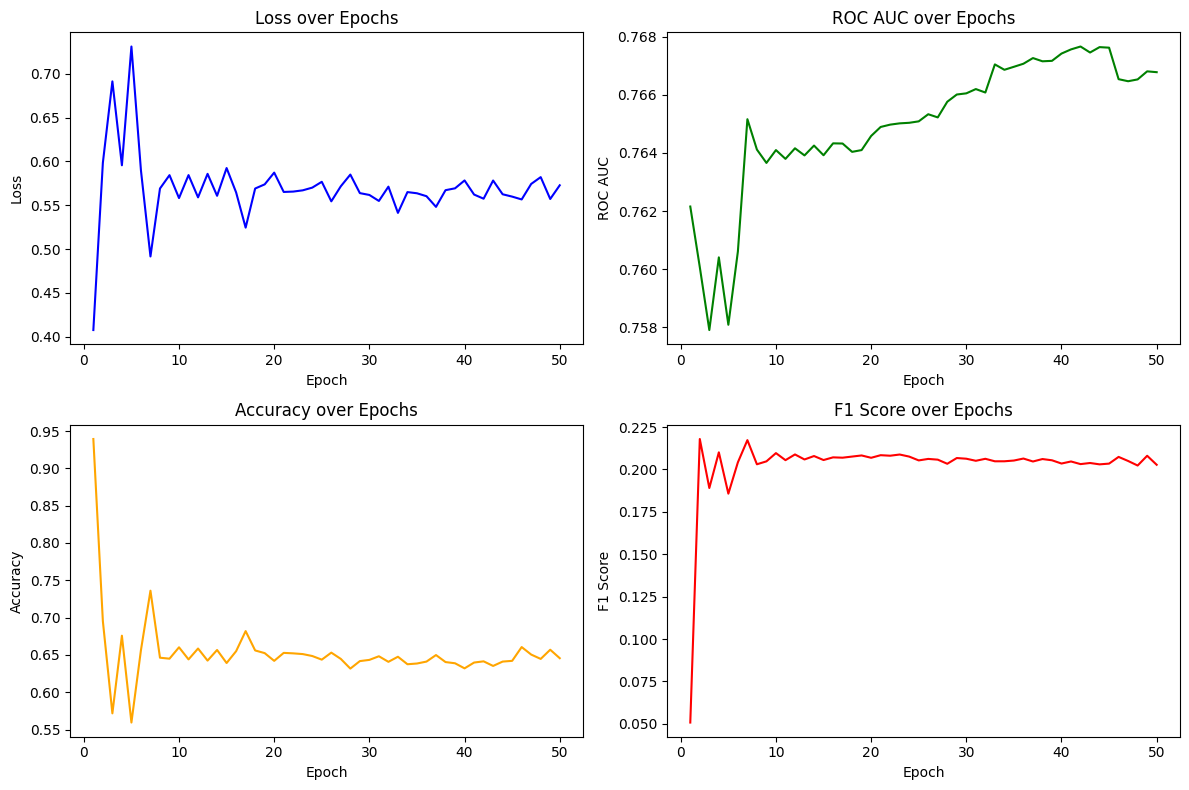

In [16]:
L, ROC_AUC, ACCURACY, F1 = client_dp.losses, client_dp.ROC_AUCs, client_dp.ACCURACYs, client_dp.F1s
plot_metrics(L, ROC_AUC, ACCURACY, F1)

In [10]:
class CustomClient_Paillier(fl.client.NumPyClient):

        
    def __init__(self, model, X_train, X_test, y_train, y_test):
        self.model = model
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.losses = []
        self.ROC_AUCs = []
        self.ACCURACYs = []
        self.F1s = []
    
        with open('../public_key.pkl', 'rb') as f:
            self.__public_key = pickle.load(f)

        with open('../private_key.pkl', 'rb') as f:
            self.__private_key = pickle.load(f)


    def get_parameters(self, config):

        print('================== INITIAL PARAMS ==================')
        params = ts.get_model_parameters(model)
        print(params)

        return params

    def fit(self, parameters, config):
        
        print('============================ PARAMS BEFORE  FIT===========================')
        
        # decrypted_params = [(self.__private_key.decrypt(value),) for param in parameters for value in param.flatten()]
        # dec_res = []
        # index = 0
        # for param in parameters:
        #        num_elements = param.size
        #        reshaped_array = np.array(decrypted_params[index:index + num_elements]).reshape(param.shape)
        #        dec_res.append(reshaped_array)
        #        index += num_elements
        # print(parameters)
        
        ts.set_model_parameters(model, parameters)
                
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(X_train, y_train)
        print(f"Training finished for round {config['server_round']}")
        print('============================= PARAMETERS AFTER FIT ===============================')
        params_1 = ts.get_model_parameters(model)
        print(f'clear: {params_1}')

        encrypted_params = [(self.__public_key.encrypt(value),) for param in params_1 for value in param.flatten()]
        enc_result = []
        index = 0

        for param in params_1:
                num_elements = param.size
                reshaped_array = np.array(encrypted_params[index:index + num_elements]).reshape(param.shape)
                enc_result.append(reshaped_array)
                index += num_elements
            # encrypt parameters here


        print(f'Encrypted: {enc_result}')
        
        return enc_result, len(X_train), {}

    def evaluate(self, parameters, config):
        print('========================== evaluate PARAMS =============================================')
        # i got agg parameters for server, here i have to decrypt them
        print(parameters, parameters[0].size, parameters[1].size)
        decrypted_params = [(self.__private_key.decrypt(value),) for param in parameters for value in param.flatten()]
        dec_res = []
        index = 0
        for param in parameters:
               num_elements = param.size
               reshaped_array = np.array(decrypted_params[index:index + num_elements]).reshape(param.shape)
               dec_res.append(reshaped_array)
               index += num_elements
        print(f' Decrypted for EVAL {dec_res}')


        
        ts.set_model_parameters(model, dec_res)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        loss = log_loss(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        f1 = f1_score(y_test, y_pred)
        print(f'accuracy: {accuracy}')
        print(f'ROC_AUC: {roc_auc}')
        print(f'f1_score: {f1}')
        self.losses.append(loss)
        self.ROC_AUCs.append(roc_auc)
        self.ACCURACYs.append(accuracy)
        self.F1s.append(f1)

        
        return loss, len(X_test), {"accuracy": accuracy, "roc_auc": roc_auc, "f1-score": f1}

if __name__ == "__main__":


    client_paillier = CustomClient_Paillier(model, X_train, X_test, y_train, y_test)
    model = LogisticRegression(
        max_iter=1,
        warm_start=True
    )

    ts.set_initial_parameters(model)

    fl.client.start_client(
        server_address="127.0.0.1:8080",
        client=client_paillier
    )

INFO :      
INFO :      Received: train message 90eb9c0b-e9cb-4edd-90d8-3190484f2767


============================ PARAMS BEFORE  FIT===========================
Training finished for round 1
============================= PARAMETERS AFTER FIT ===============================
clear: [array([[-3.67152661e-02, -8.75604181e-02, -2.90514321e-02,
        -7.25983055e-02, -4.26906494e-02, -2.74191021e-02,
        -2.67323236e-02, -5.14038004e-02,  1.75825247e-01,
        -2.02401841e-02, -5.06665123e-02, -6.31777197e-01,
        -9.51778410e-02, -3.01756534e-01,  8.68778597e-02,
        -5.51477086e-02, -5.75119838e-02,  1.81104068e-02,
         2.46935377e-02, -1.89446278e-02, -4.21954231e-03,
        -1.73996087e-01, -5.29620824e-02, -5.01387830e-02,
        -1.55281095e-02, -3.37363466e-02, -1.09346006e-01,
        -1.34546277e-02, -2.41253103e-04, -8.47200051e-02,
        -6.09664163e-01,  0.00000000e+00,  5.09946752e-02]]), array([2.68379644e-16])]


INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000002C8BA6571F0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000002C8BA68D480>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message 3d01f72c-f7a2-4d00-b3a5-35b15f10da4d


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000002C8BA68EDD0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000002C8BA68C4C0>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message 3f582562-6703-4c5f-b963-e45efdc72de0
ERROR :     Client raised an exception.
Traceback (most recent call last):
  File "c:\Users\Астемир\.pyenv\pyenv-win\versions\3.10.6\lib\site-packages\flwr\client\app.py", line 379, in _start_client_internal
    reply_message = client_app(message=message, context=context)
  File "c:\Users\Астемир\.pyenv\pyenv-win\versions\3.10.6\lib\site-packages\flwr\client\client_app.py", line 98, in __call__
    return self._call(message, context)
  File "c:\Users\Астемир\.pyenv\pyenv-win\versions\3.10.6\lib\site-packages\flwr\client\client_app.py", line 81, in ffn
    out_message = handle_legacy_message_from_msgtype(
  File "c:\Users\Астемир\.pyenv\pyenv-win\versions\3.10.6\lib\site-packages\flwr\client\message_handler\message_handler.py", line 130, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
  File "c:\Users\Астемир\.pyenv\pyenv-win\versions\3.10.6\lib\site-packages\

 Decrypted for EVAL [array([[-0.04035642, -0.06838285, -0.04901064, -0.08041477, -0.05967494,
         0.0137327 , -0.05450042, -0.0270502 ,  0.1934429 , -0.01912221,
        -0.06654014, -0.60300138, -0.08105414, -0.28374685,  0.08911177,
        -0.06062822, -0.00356938,  0.00323606,  0.0363628 , -0.00799729,
        -0.00237556, -0.21984822, -0.07152266, -0.0411051 , -0.00924902,
        -0.03192408, -0.15789523, -0.01266152, -0.00180927, -0.0951876 ,
        -0.60414156,  0.        ,  0.0384818 ]]), array([2.60270951e-16])]
accuracy: 0.9393644617380026
ROC_AUC: 0.7621556473829201
f1_score: 0.050761421319796954
============================ PARAMS BEFORE  FIT===========================


TypeError: float() argument must be a string or a real number, not 'EncryptedNumber'

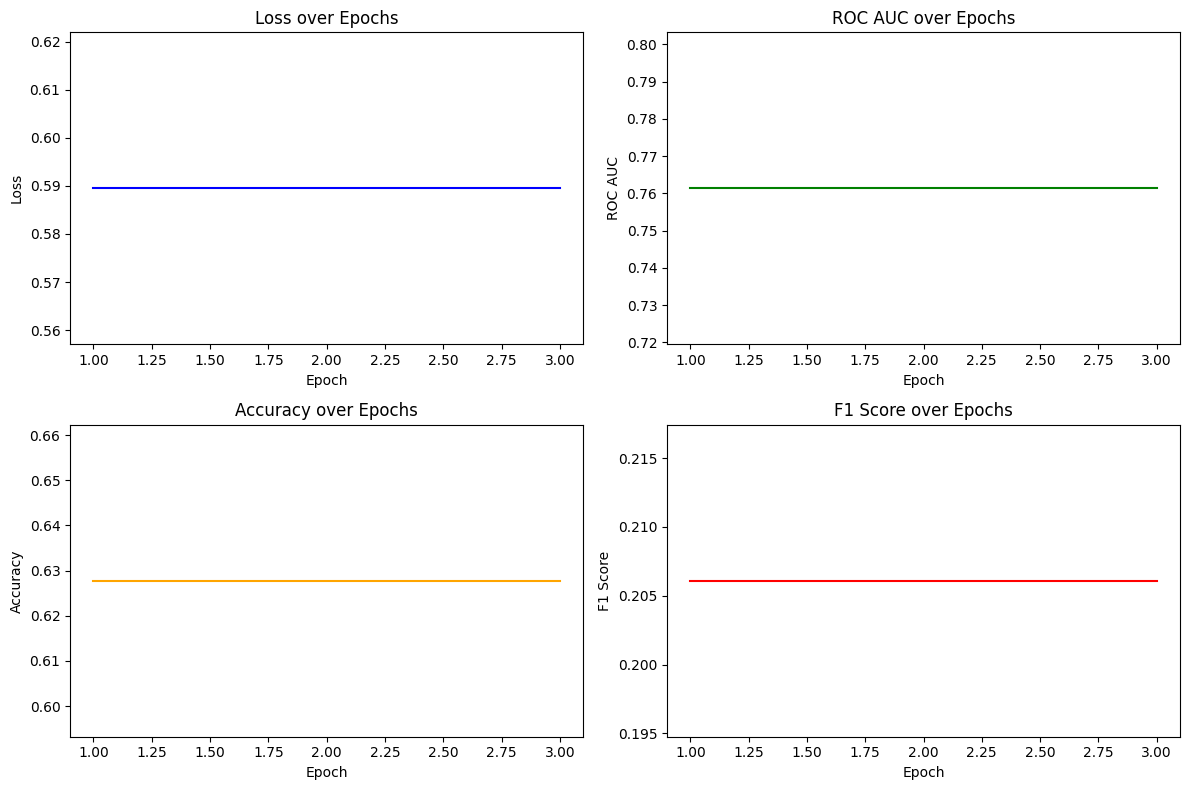

In [108]:
L, ROC_AUC, ACCURACY, F1 = client_paillier.losses, client_paillier.ROC_AUCs, client_paillier.ACCURACYs, client_paillier.F1s
plot_metrics(L, ROC_AUC, ACCURACY, F1)

In [12]:
ts.__dict__

{'__name__': 'tasks',
 '__doc__': None,
 '__package__': '',
 '__loader__': <_frozen_importlib_external.SourceFileLoader at 0x2191267fc10>,
 '__spec__': ModuleSpec(name='tasks', loader=<_frozen_importlib_external.SourceFileLoader object at 0x000002191267FC10>, origin='c:\\Users\\Астемир\\Desktop\\Flwr\\FedAvg\\tasks.py'),
 '__file__': 'c:\\Users\\Астемир\\Desktop\\Flwr\\FedAvg\\tasks.py',
 '__cached__': 'c:\\Users\\Астемир\\Desktop\\Flwr\\FedAvg\\__pycache__\\tasks.cpython-310.pyc',
 '__builtins__': {'__name__': 'builtins',
  '__doc__': "Built-in functions, exceptions, and other objects.\n\nNoteworthy: None is the `nil' object; Ellipsis represents `...' in slices.",
  '__package__': '',
  '__loader__': _frozen_importlib.BuiltinImporter,
  '__spec__': ModuleSpec(name='builtins', loader=<class '_frozen_importlib.BuiltinImporter'>, origin='built-in'),
  '__build_class__': <function __build_class__>,
  '__import__': <function __import__>,
  'abs': <function abs(x, /)>,
  'all': <function al

In [14]:
# class CustomClient(fl.client.NumPyClient):
    
#     def __init__(self):
        
#         super().__init__()
#         self.lOSS = []
#         self.ROC_AUC = []
#         self.ACCURACY = []
#         self.F1 = []



#     def fit(self, parameters, config):
#         ts.set_model_parameters(model, parameters)
#         print(f'STUDY ::: [LOCAL FIT]')
       
#         with warnings.catch_warnings():
#             warnings.simplefilter("ignore")
#             model.fit(X_train_2, y_train_2)
        
#         return ts.get_model_parameters(model), len(X_train_2), {}

#     def evaluate(self, parameters, config):
#         print(f'STUDY ::: [EVALUATE]')
#         ts.set_model_parameters(model, parameters)
        
#         y_pred_proba = model.predict_proba(X_test_scale)[:, 1]
#         y_pred = model.predict(X_test_scale)
        
#         loss = log_loss(y_test, y_pred_proba)
#         accuracy = accuracy_score(y_test, y_pred)
#         roc_auc = roc_auc_score(y_test, y_pred_proba)
#         f1 = f1_score(y_test, y_pred)

#         print(f'Accuracy: {accuracy}')
#         print(f'ROC_AUC: {roc_auc}')
#         print(f'F1_score: {f1}')

#         self.lOSS.append(loss)
#         self.ROC_AUC.append(roc_auc)
#         self.ACCURACY.append(accuracy)
#         self.F1.append(f1)
        
        
#         return loss, len(X_test_scale), {"accuracy": accuracy, "roc_auc": roc_auc, "f1-score": f1}


# if __name__ == "__main__":
    
#     N_CLIENTS = 2

#     model = LogisticRegression(
#         penalty='l2',
#         max_iter=10
#     )

#     ts.set_initial_parameters(model)
    
    
#     client = CustomClient()

    
#     fl.client.start_client(
#         server_address="127.0.0.1:8080",
#         client=client
#     )

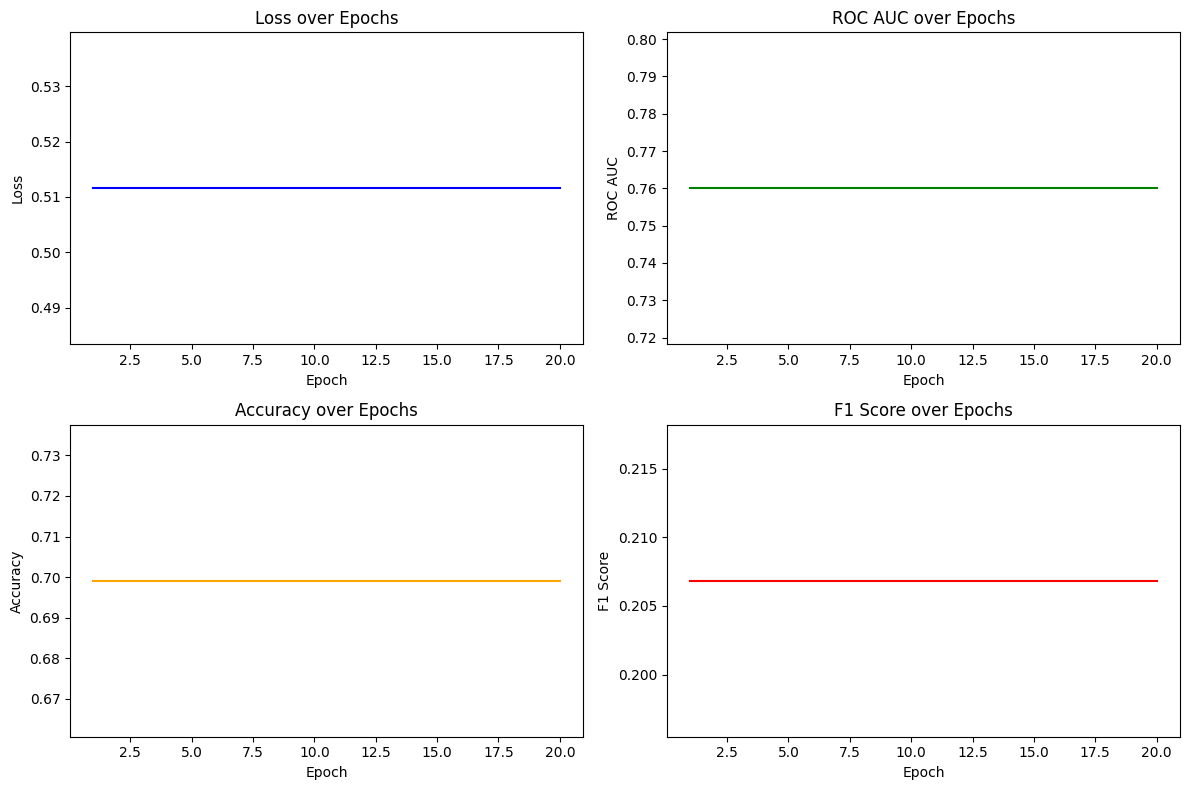

In [17]:
L, ROC_AUC, ACCURACY, F1 = client.lOSS, client.ROC_AUC, client.ACCURACY, client.F1
plot_metrics(L, ROC_AUC, ACCURACY, F1)